# Quantum Dropout for QAOA

## Overview

Quantum Approximation Optimization Algorithm (QAOA) is a hybrid classical-quantum algorithm used for solving the combinatorial optimization problem, which is proposed by [Farhi, Goldstone, and Gutmann (2014)](https://arxiv.org/abs/1411.4028). In the [previous tutorial](qaoa_nae3sat.ipynb), we introduced solving the [Not-all-equal 3-satisfiability (NAE3SAT)](https://en.wikipedia.org/wiki/Not-all-equal_3-satisfiability) by QAOA and the dilemma of QAOA on the hard problem. In this tutorial, we will introduce a simple trick to alleviate this dilemma, namely quantum dropout, please refer to [Wang, Zheng, Wu, and Zhang (2023)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.023171) for more details.

## NAE3SAT and Hard Problem

Let's briefly review the NAE3SAT and the difference between the easy and hard problem.

Let the set of clauses in the NAE3SAT be $\mathcal{C}$. In each clause, there are three literals and each literal is represented by a spin. Spins up ($s=1$, $\text{bit}=0$) and down ($s=-1$, $\text{bit}=1$) represent false and true respectively. NAE3SAT requires the three spins in each clause are not all equal to each other, in other words, at least one is up, and at least one is down. The Hamiltonian of the NAE3SAT is as follows
$$
\begin{split}
    \hat{H}_C&=\sum_{(i,j,k)\in\mathcal{C}}\left[(s_i+s_j+s_k)^2-1\right]/2\\
    &=\sum_{(i,j,k)\in\mathcal{C}}(s_i s_j+s_j s_k+s_k s_i)+|\mathcal{C}|,
\end{split}
$$
where $|\mathcal{C}|$ is the number of clauses in $\mathcal{C}$. When all clauses are true, $\hat{H}_C$ takes the minimum value 0, and the corresponding bit string is the solution of the NAE3SAT.

The difference between the easy and hard problem is the energy landscape, as shown in the following figure.

<img src="../statics/landscape.jpg">

The global minimum is located in a large and smooth neighborhood for a simpler problem and a narrow region for a harder problem. It is worth noting that when the system size is relatively small, most of the randomly generated problems are easy, and hard problems need to be constructed with special methods, please refer to [Wang, Zheng, Wu, and Zhang (2023)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.023171).

## Quantum Dropout

The algorithm is shown in the following figure.

<img src="../statics/qd_alg.jpg">

We first implement the classical algorithm that can be done in polynomial time, such as simulated annealing method (SA). If the result is satisfactory, we stop the procedure since there is no point in a quantum solver. Otherwise, these failed classical results, typically low-lying excited states (local minima), offer insights as we prepare quantum dropout for QAOA: whether a clause should be kept or available for quantum dropout to underweight the distracting local minima and enhance the chances to locate the true ground state. Specifically, the clauses violated by low-lying excited states should be all kept, and the other clauses can be randomly discarded at the ratio $R$.

Finally, we optimize the PQC with respect to the original cost function $H_C$ with a complete set of clauses to ensure the uniqueness of the global minimum. The current procedure does not incur obvious overhead to the conventional QAOA since the preliminary approaches and the quantum-dropout controls are both inexpensive on a classical computer.

### Setup

In [ ]:
import tensorcircuit as tc
import optax
import jax.numpy as jnp
import tensorflow as tf
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from IPython.display import clear_output
import random

K = tc.set_backend("jax")

nlayers = 30  # the number of layers
ncircuits = 6  # six circuits with different initial parameters are going to be optimized at the same time
R = 0.5  # dropout ratio, 0 means no dropout, 1 means all dropout

We use the same NAE3SAT as the [previous tutorial](qaoa_nae3sat.ipynb).

In [2]:
# a hard graph instance
hard_clauses = [
    [4, 1, 7],
    [5, 11, 8],
    [4, 1, 8],
    [4, 11, 8],
    [4, 1, 10],
    [5, 11, 8],
    [4, 1, 8],
    [1, 11, 8],
    [4, 1, 7],
    [0, 11, 8],
    [4, 1, 10],
    [4, 11, 8],
    [5, 0, 10],
    [0, 6, 7],
    [5, 0, 11],
    [0, 6, 7],
    [5, 0, 9],
    [3, 6, 7],
    [5, 0, 8],
    [5, 6, 7],
    [5, 0, 10],
    [3, 6, 7],
    [5, 0, 10],
    [1, 6, 7],
    [2, 4, 6],
    [1, 8, 11],
    [2, 4, 6],
    [2, 8, 11],
    [2, 4, 9],
    [5, 8, 11],
    [2, 4, 10],
    [2, 8, 11],
    [2, 4, 10],
    [4, 8, 11],
    [2, 4, 8],
    [4, 8, 11],
    [3, 0, 9],
    [5, 11, 7],
    [3, 0, 10],
    [2, 11, 7],
    [3, 0, 9],
    [0, 11, 7],
    [3, 0, 9],
    [5, 11, 7],
    [3, 0, 10],
    [3, 11, 7],
    [3, 0, 7],
    [4, 11, 7],
    [5, 0, 10],
    [4, 0, 10],
    [2, 5, 6],
    [2, 11, 10],
    [2, 6, 10],
    [2, 4, 9],
    [0, 9, 10],
    [3, 0, 7],
    [2, 5, 6],
    [1, 10, 9],
    [1, 4, 11],
    [5, 10, 11],
    [0, 4, 8],
    [0, 9, 8],
    [2, 11, 10],
    [2, 8, 6],
    [3, 6, 7],
    [0, 8, 10],
    [4, 0, 9],
    [3, 5, 8],
    [5, 11, 10],
    [2, 11, 10],
    [4, 11, 8],
    [1, 3, 11],
]
cost_factor = 1 / len(hard_clauses) / 4

In [3]:
# convert to a NetworkX graph
def construct_graph(clauses):
    graph = nx.Graph()
    for i, j, k in clauses:
        graph.add_edge(i, j, weight=0)
        graph.add_edge(j, k, weight=0)
        graph.add_edge(k, i, weight=0)
    for i, j, k in clauses:
        graph[i][j]["weight"] += 1
        graph[j][k]["weight"] += 1
        graph[k][i]["weight"] += 1
    return graph

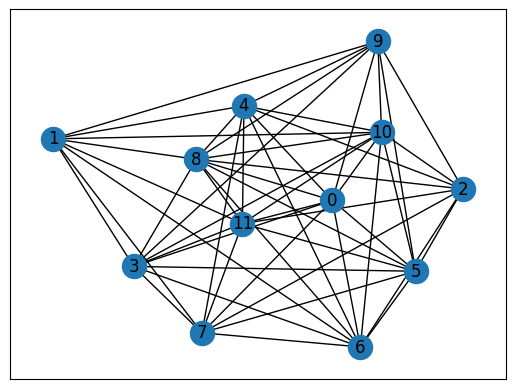

In [4]:
# plot original hard graph
hard_graph = construct_graph(hard_clauses)
pos = nx.spring_layout(hard_graph)
nx.draw_networkx(hard_graph, with_labels=True, pos=pos)
ax = plt.gca()
ax.set_facecolor("w")

We first use the brutal force method (BF) to obtain the true solution.

In [5]:
def b2s(bit):
    return 1 - 2 * int(bit)


def energy(cfg, graph, n_cls, normalize=True):
    factor = 1 / n_cls / 4
    E = 0.25
    for a, b in graph.edges:
        E += cfg[a] * cfg[b] * graph[a][b]["weight"] * factor
    return E if normalize else E / factor


def brutal_force(graph):
    num_nodes, n_cls = graph.number_of_nodes(), len(hard_clauses)
    min_cost, best_case = 1.0, []
    for i in range(2**num_nodes):
        case = f"{bin(i)[2:]:0>{num_nodes}}"

        cost = energy(list(map(b2s, case)), graph, n_cls)

        gap = min_cost - cost
        if gap > 1e-6:
            min_cost = cost
            best_case = [case]
        elif abs(gap) < 1e-6:
            best_case.append(case)

    return best_case, min_cost

cost: 0.000
bit string: ['000000111111', '111111000000']


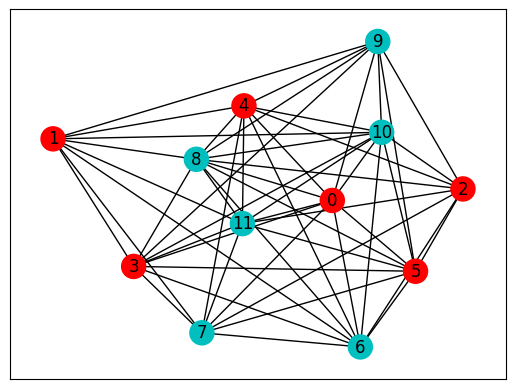

In [6]:
# print BF results
bf_best_cases, bf_best = brutal_force(hard_graph)
print(f"cost: {bf_best:.3f}\nbit string: {bf_best_cases}")

# plot NetworkX graph
colors = ["r" if bf_best_cases[0][i] == "0" else "c" for i in hard_graph.nodes]
nx.draw_networkx(hard_graph, with_labels=True, node_color=colors, pos=pos)
ax = plt.gca()
ax.set_facecolor("w")

Then we start to execute the algorithm loop shown in the figure above. The algorithm starts from the classical method - SA.

In [7]:
def sim_annealing(graph, t_max: int, T: float):
    num_nodes, num_cls = graph.number_of_nodes(), len(hard_clauses)
    state = np.random.randint(0, 2, num_nodes)
    next_state = state.copy()
    E = energy(1 - 2 * state, graph, num_cls, normalize=False)
    t = 0
    while t < t_max:
        temper = (1 - t / t_max) * T
        flip_idx = np.random.randint(num_nodes)
        next_state[flip_idx] = 1 - next_state[flip_idx]
        next_E = energy(1 - 2 * next_state, graph, num_cls, normalize=False)
        if next_E <= E or np.exp(-(next_E - E) / temper) > np.random.rand():
            state[flip_idx] = 1 - state[flip_idx]
            E = next_E
        else:
            next_state[flip_idx] = 1 - next_state[flip_idx]
        t += 1
    return tuple(state), E

In [8]:
# obtain the low-lying excited states
ll_excited, n_exp = set(), 100
for _ in range(n_exp):
    sa_case, sa_cost = sim_annealing(hard_graph, 200, 1)
    if sa_cost > 1e-6:
        ll_excited.add(sa_case)
print(f"number of low-lying excited states: {len(ll_excited)}")

number of low-lying excited states: 23


In [9]:
# obtain the clauses violated by low-lying excited states and the clauses can be discarded
def get_clauses(ll_exc_st, clauses):
    kept, drop = [], []
    for cls in clauses:
        violated = False
        for state in ll_exc_st:
            if sum(state[i] for i in cls) in [0, 3]:
                kept.append(cls)
                violated = True
                break
        if not violated:
            drop.append(cls)
    return kept, drop


kept_clauses, drop_clauses = get_clauses(ll_excited, hard_clauses)
num_selected = int((1 - R) * len(drop_clauses))
num_after_drop = len(kept_clauses) + num_selected
driving_factor = 1 / num_after_drop / 4
print(f"number of clauses should be kept: {len(kept_clauses)}")
print(f"number of clauses can be discarded: {len(drop_clauses)}")
print(f"number of clauses after dropout: {num_after_drop}")

number of clauses should be kept: 12
number of clauses can be discarded: 60
number of clauses after dropout: 42


There are two ways of quantum dropout. One isotropic or uniform, i.e., $\hat H_{C_1} = \hat H_{C_2} = \cdots = \hat H_{C_p}$. The other is random or different, i.e., $\hat H_{C_i}\neq\hat H_{C_j}$ if $i\neq j$.

### Isotropic Quantum Dropout

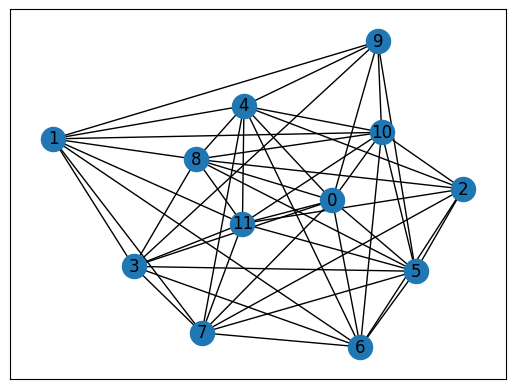

In [10]:
# get the graph after dropout
iso_clauses = kept_clauses + random.sample(drop_clauses, num_selected)
iso_graph = construct_graph(iso_clauses)
nx.draw_networkx(iso_graph, with_labels=True, pos=pos)
ax = plt.gca()
ax.set_facecolor("w")

The PQC is similar to the regular QAOA, but the cost Hamiltonian is the original Hamiltonian but the driving Hamiltonian is the one after dropout.

In [11]:
def QAOAansatz_iso(params, g, each=1, return_circuit=False):
    n = g.number_of_nodes()  # the number of nodes

    # PQC loop
    def pqc_loop(s_, params_):
        c_ = tc.Circuit(n, inputs=s_)
        for j in range(each):
            # driving layer
            for a, b in g.edges:
                c_.RZZ(a, b, theta=g[a][b]["weight"] * params_[2 * j] * driving_factor)
            # mixing layer
            for i in range(n):
                c_.RX(i, theta=params_[2 * j + 1])
        s_ = c_.state()
        return s_

    c0 = tc.Circuit(n)
    for i in range(n):
        c0.H(i)
    s0 = c0.state()
    s = K.scan(pqc_loop, K.reshape(params, [nlayers // each, 2 * each]), s0)
    c = tc.Circuit(n, inputs=s)

    # whether to return the circuit
    if return_circuit is True:
        return c

    # calculate the loss function
    loss = 0.25
    for a, b in hard_graph.edges:
        loss += c.expectation_ps(z=[a, b]) * hard_graph[a][b]["weight"] * cost_factor

    return K.real(loss)

Here, several circuits with different initial parameters are optimized/trained at the same time.

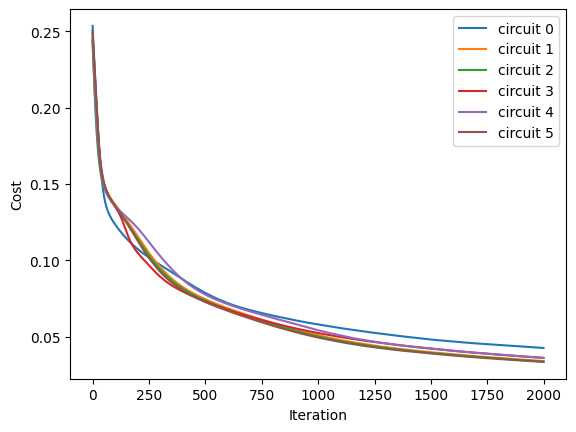

In [12]:
# use vvag to get the losses and gradients with different random circuit instances
QAOA_vvag = K.jit(
    K.vvag(QAOAansatz_iso, argnums=0, vectorized_argnums=0), static_argnums=(1, 2, 3)
)

params_iso = K.implicit_randn(
    shape=[ncircuits, 2 * nlayers], stddev=0.1
)  # initial parameters
if type(K).__name__ == "JaxBackend":
    opt = K.optimizer(optax.adam(1e-2))
else:
    opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

list_of_loss = [[] for i in range(ncircuits)]

for i in range(2000):
    loss, grads = QAOA_vvag(params_iso, iso_graph)
    params_iso = opt.update(grads, params_iso)  # gradient descent

    # visualise the progress
    clear_output(wait=True)
    list_of_loss = np.hstack((list_of_loss, K.numpy(loss)[:, np.newaxis]))
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    for index in range(ncircuits):
        plt.plot(range(i + 1), list_of_loss[index])
    legend = [f"circuit {leg}" for leg in range(ncircuits)]
    plt.legend(legend)
    plt.show()

After inputting the optimized parameters back to the ansatz circuit, we can perform the projective measurement on the output quantum state to get the solution. Here we directly use the bit string with the maximum probability as the solution since we know all information of the probability distribution of the output quantum state, but which is not feasible in the experiment.

In [13]:
# print QAOA results
for num_circuit in range(ncircuits):
    print(f"Circuit #{num_circuit}")
    c = QAOAansatz_iso(params=params_iso[num_circuit], g=iso_graph, return_circuit=True)
    loss = QAOAansatz_iso(params=params_iso[num_circuit], g=iso_graph)

    # find the states with max probabilities
    probs = K.numpy(c.probability())
    max_prob = max(probs)
    index = np.where(probs == max_prob)[0]
    states = []
    for i in index:
        states.append(f"{bin(i)[2:]:0>{c._nqubits}}")
    print(f"cost: {K.numpy(loss)}\nmax prob: {max_prob}\nbit strings: {states}\n")

Circuit #0
cost: 0.042537812143564224
max prob: 0.047906018793582916
bit strings: ['000000111111']

Circuit #1
cost: 0.033970173448324203
max prob: 0.054868899285793304
bit strings: ['000000111111']

Circuit #2
cost: 0.033648744225502014
max prob: 0.055139534175395966
bit strings: ['111111000000']

Circuit #3
cost: 0.03602508455514908
max prob: 0.05475332960486412
bit strings: ['111111000000']

Circuit #4
cost: 0.03601868823170662
max prob: 0.05406792089343071
bit strings: ['111111000000']

Circuit #5
cost: 0.03338256850838661
max prob: 0.05537496879696846
bit strings: ['000000111111']



On average, QAOA with isotropic quantum dropout improves the probability of correct solution (max prob) by nearly 0.015 compared to regular QAOA.

It should be noted that isotropic quantum dropout will lead to more ground state degeneracy, so it does not necessarily lead to better results than conventional QAOA. However, it has a high upper limit, which means that it is possible to get much better results, please refer to [Wang, Zheng, Wu, and Zhang (2023)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.023171) for more analysis and details.

### Random Quantum Dropout

Because the dropout of each layer is different, we need to generate $\text{nlayers}$ graphs after dropout. In order to perform just-in-time (JIT) compilation more conveniently, here we only save the weights in the order of the edges of the original hard graph, instead of saving each graph after dropout.

In [21]:
def graph_weights(graph):
    gw = []
    for a, b in hard_graph.edges:
        gw.append(graph[a].get(b, default={"weight": 0})["weight"])
    return jnp.asarray(gw)

Here is the graph of the H_C of the last driving layer:


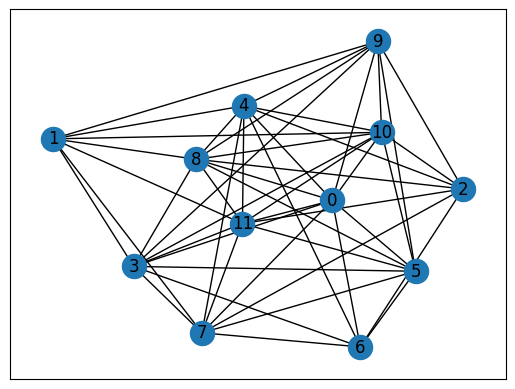

In [22]:
# get the graph after dropout
rnd_graphs_w = []
for _ in range(nlayers):
    rnd_clauses = kept_clauses + random.sample(drop_clauses, num_selected)
    rnd_graph = construct_graph(rnd_clauses)
    rnd_graphs_w.append(graph_weights(rnd_graph))
print("Here is the graph of the H_C of the last driving layer:")
rnd_graphs_w = jnp.stack(rnd_graphs_w, axis=0)
nx.draw_networkx(rnd_graph, with_labels=True, pos=pos)
ax = plt.gca()
ax.set_facecolor("w")

The ansatz needs to accept $\text{nlayers}$ weights of graphs as inputs.

In [23]:
def QAOAansatz_rnd(params, g, each=1, return_circuit=False):
    n = hard_graph.number_of_nodes()  # the number of nodes
    rep = nlayers // each
    g = g.reshape(rep, each, g.shape[-1]) * driving_factor

    # PQC loop
    def pqc_loop(s_, pkg):
        params_, g_ = pkg
        c_ = tc.Circuit(n, inputs=s_)
        for j in range(each):
            # driving layer
            for i, (a, b) in enumerate(hard_graph.edges):
                c_.RZZ(a, b, theta=g_[j][i] * params_[2 * j])
            # mixing layer
            for i in range(n):
                c_.RX(i, theta=params_[2 * j + 1])
        s_ = c_.state()
        return s_

    c0 = tc.Circuit(n)
    for i in range(n):
        c0.H(i)
    s0 = c0.state()
    s = K.scan(pqc_loop, [K.reshape(params, [rep, 2 * each]), g], s0)
    c = tc.Circuit(n, inputs=s)

    # whether to return the circuit
    if return_circuit is True:
        return c

    # calculate the loss function
    loss = 0.25
    for a, b in hard_graph.edges:
        loss += c.expectation_ps(z=[a, b]) * hard_graph[a][b]["weight"] * cost_factor

    return K.real(loss)

Then, we perform the optimization step, and also optimize several circuits in parallel. Since graph weights Jax arrays are non-hashable static arguments and not supported when using vmap, we use $\text{partial}$ to wrap the ansatz and accept the graph weights input.

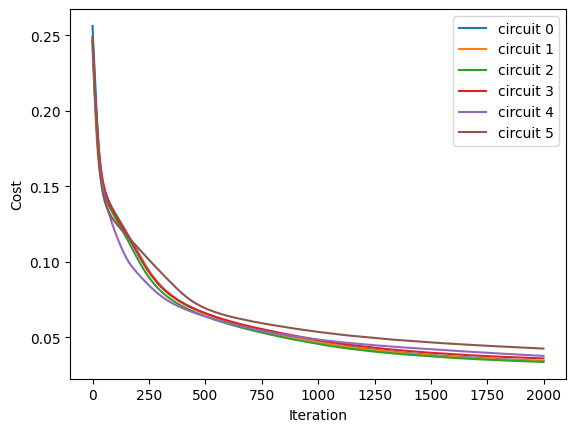

In [28]:
# use vvag to get the losses and gradients with different random circuit instances
QAOA_vvag = K.jit(
    K.vvag(partial(QAOAansatz_rnd, g=rnd_graphs_w), argnums=0, vectorized_argnums=0)
)

params_rnd = K.implicit_randn(
    shape=[ncircuits, 2 * nlayers], stddev=0.1
)  # initial parameters
if type(K).__name__ == "JaxBackend":
    opt = K.optimizer(optax.adam(1e-2))
else:
    opt = K.optimizer(tf.keras.optimizers.Adam(1e-2))

list_of_loss = [[] for i in range(ncircuits)]

for i in range(2000):
    loss, grads = QAOA_vvag(params_rnd)
    params_rnd = opt.update(grads, params_rnd)  # gradient descent

    # visualise the progress
    clear_output(wait=True)
    list_of_loss = np.hstack((list_of_loss, K.numpy(loss)[:, np.newaxis]))
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    for index in range(ncircuits):
        plt.plot(range(i + 1), list_of_loss[index])
    legend = [f"circuit {leg}" for leg in range(ncircuits)]
    plt.legend(legend)
    plt.show()

In [29]:
# print QAOA results
for num_circuit in range(ncircuits):
    print(f"Circuit #{num_circuit}")
    c = QAOAansatz_rnd(
        params=params_rnd[num_circuit], g=rnd_graphs_w, return_circuit=True
    )
    loss = QAOAansatz_rnd(params=params_rnd[num_circuit], g=rnd_graphs_w)

    # find the states with max probabilities
    probs = K.numpy(c.probability())
    max_prob = max(probs)
    index = np.where(probs == max_prob)[0]
    states = []
    for i in index:
        states.append(f"{bin(i)[2:]:0>{c._nqubits}}")
    print(f"cost: {K.numpy(loss)}\nmax prob: {max_prob}\nbit strings: {states}\n")

Circuit #0
cost: 0.034298673272132874
max prob: 0.061373475939035416
bit strings: ['000000111111']

Circuit #1
cost: 0.034172173589468
max prob: 0.06166590005159378
bit strings: ['000000111111', '111111000000']

Circuit #2
cost: 0.03370116278529167
max prob: 0.06229700148105621
bit strings: ['000000111111']

Circuit #3
cost: 0.035995520651340485
max prob: 0.0600101463496685
bit strings: ['111111000000']

Circuit #4
cost: 0.03770057111978531
max prob: 0.05639055743813515
bit strings: ['000000111111']

Circuit #5
cost: 0.042536795139312744
max prob: 0.047668762505054474
bit strings: ['111111000000']



On average, QAOA with random quantum dropout improves the probability of correct solution (max prob) by nearly 0.02 compared to regular QAOA.

Compared with isotropic quantum dropout, the standard deviation of the probability of correct solution obtained by random quantum dropout is smaller, but the upper limit is lower. From the physical picture, QAOA after random quantum dropout works like a quantum interferometer. QAOA circuits with different dropouts over driving layers may work through a focusing effect on the true ground state: different clause sets lead to different energy landscapes and minima, whose configurations receive constructive interference and enhanced amplitudes. Being the only common minimum of all $\hat{H}_{C_i}$ irrespective of the dropouts, the true ground state remains stand-out through all driving layers. Please refer to [Wang, Zheng, Wu, and Zhang (2023)](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.023171) for more analysis and details.

In [30]:
tc.about()

OS info: Linux-5.4.119-1-tlinux4-0010.2-x86_64-with-glibc2.28
Python version: 3.10.11
Numpy version: 1.23.5
Scipy version: 1.11.0
Pandas version: 2.0.2
TensorNetwork version: 0.4.6
Cotengra is not installed
TensorFlow version: 2.12.0
TensorFlow GPU: []
TensorFlow CUDA infos: {'cpu_compiler': '/dt9/usr/bin/gcc', 'cuda_compute_capabilities': ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80'], 'cuda_version': '11.8', 'cudnn_version': '8', 'is_cuda_build': True, 'is_rocm_build': False, 'is_tensorrt_build': True}
Jax version: 0.4.13
Jax installation doesn't support GPU
JaxLib version: 0.4.13
PyTorch version: 2.0.1
PyTorch GPU support: False
PyTorch GPUs: []
Cupy is not installed
Qiskit version: 0.24.1
Cirq version: 1.1.0
TensorCircuit version 0.10.0
